In [1]:
#install import stuff
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!pip install -U keras

gpg: keybox '/tmp/tmpkl4l7kcr/pubring.gpg' created
gpg: /tmp/tmpkl4l7kcr/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········
Requirement already up-to-date: keras in /usr/local/lib/python2.7/dist-packages (2.2.0)
Requirement not upgraded as not directly required: keras-preprocessing==1.0.1 in /usr/local/lib/python2.7/dist-packages (from keras) (1.0.1)
Requirement not upgraded as not directly required: numpy>=1.9.1 in /usr/local/lib/python2.7/dist-packages (from keras) (1.14.5)
Requirement not upgraded as not directly required: keras-applications==1.0.2 in /usr/local/lib/python2.7/dist-packages (from keras) (1.0.2)
Requirement not upgraded as not directly required: h5py in /usr/local/lib/python2.7/dist-packages (from keras) (2.8.0)
Requirement not upgraded as not directly required: scipy>=0.14 in /usr/local/lib/python2.7/dist-packages (from keras) (0.19.

In [2]:
#mount google drive
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [3]:
%cd
%cd drive
%mkdir shapley_mnist
%cd shapley_mnist
#download model parameters
!if [ ! -f "mnist.h5" ]; then wget https://www.dropbox.com/s/dvgrcza2roul0ug/mnist.h5?dl=0 -O mnist.h5 ; fi
!if [ ! -f "dictt_BetterSampling_mnist.npy.gz" ]; then wget https://www.dropbox.com/s/l1mrzntyjp5mmbx/dictt_BetterSampling_mnist.npy.gz?dl=0 -O dictt_BetterSampling_mnist.npy.gz ; fi
%ls -lh */
%ls -lh


/content
/content/drive
mkdir: cannot create directory ‘shapley_mnist’: File exists
/content/drive/shapley_mnist
total 12M
-rw-r--r-- 1 root root 1.6M Jul 23 06:04 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Jul 23 06:04 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Jul 23 06:04 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Jul 23 06:04 train-labels-idx1-ubyte.gz
total 23M
-rw-r--r-- 1 root root  12M Jul 23 06:21 dictt_BetterSampling_mnist.npy.gz
drwxr-xr-x 2 root root 4.0K Jul 23 06:03 MNIST_data/
-rw-r--r-- 1 root root 3.5M Jul 23 06:14 mnist.h5
-rw-r--r-- 1 root root 3.5M Jul 23 06:09 mnist.h5?dl=0
-rw-r--r-- 1 root root 3.5M Jul 23 06:12 mnist.h5#download
-rw-r--r-- 1 root root 1.1M Jul 23 06:42 Visual.png


In [4]:
# -*- coding: utf-8 -*-
#import matplotlib.pyplot as plt
import numpy as np
import gzip
import keras

from keras.layers import Input



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



#https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
model = Sequential()
Input 
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


model.summary()
batch_size = 64

X_train = mnist.train.images
X_train = np.reshape(X_train,(X_train.shape[0],28,28,1))
X_val = mnist.test.images
X_val = np.reshape(X_val,(X_val.shape[0],28,28,1))[::1]
y_train = mnist.train.labels
y_val = mnist.test.labels[::1]

import os
if 'mnist.h5' not in os.listdir('.'):
    print ('weights not found, training model')
  # With data augmentation to prevent overfitting (accuracy 0.99286)
    datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images
    batch_size = 64
    epochs = 20
    X_train = mnist.train.images
    X_train = np.reshape(X_train,(X_train.shape[0],28,28,1))
    X_val = mnist.test.images
    X_val = np.reshape(X_val,(X_val.shape[0],28,28,1))
    Y_train = mnist.train.labels
    Y_val = mnist.test.labels
    datagen.fit(X_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val,Y_val),
                                  verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                                  , callbacks=[learning_rate_reduction])
    model.save_weights('mnist.h5')
  
  
else:
    print ('weights are found, loading weights')
    model.load_weights('mnist.h5') 



Using TensorFlow backend.


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2

In [0]:
print ('predicting train set')
pred = model.predict(X_train[::5],batch_size =512)
pred2 = np.argmax(pred,1)
print  ('Estimated Accuracy of train set',np.mean(pred2==np.argmax(y_train[::5],1)))
print  ('Esimated Inaccurately predicted',10*np.sum(pred2!=np.argmax(y_train[::5],1)))
print ('Total train set size',5*len(pred))
print ('predicting test set')
pred = model.predict(X_val,batch_size =512)
pred2 = np.argmax(pred,1)
print  ('Accuracy of test set',np.mean(pred2==np.argmax(y_val,1)))
print  ('Inaccurately predicted',np.sum(pred2!=np.argmax(y_val,1)))
print ('Total test set size',len(pred))

predicting train set


In [12]:
import gzip
print ('loading pre computed shapley values')
dictt = np.load(gzip.GzipFile('dictt_BetterSampling_mnist.npy.gz')).item()

### WARNING THIS WILL PRINT MANY MANY THINGS ###
if False: #uncomment to compute shapley values
      print ('### WARNING THIS WILL PRINT MANY MANY THINGS ###')
      X_val_ids_to_compute = range(len(X_val))[::]
      pred2 = np.argmax(pred,1)
      import gc
      filename= 'dictt_BetterSampling_mnist.npy'
      def slic(img, n_segments=49, compactness=10, sigma=0.5):
          new_img = np.copy(img[:,:,0])
          counter =0
          for i in range(0,28,4)[:]:
              for j in range(0,28,4)[:]:
                  a,b = 4,4
                  new_img[i:i+a,j:j+b] = counter
                  counter += 1
          return new_img.astype(np.int32)
      import itertools
      import scipy
      dictt ={}
      import os
      if filename+'.gz' in os.listdir('.'):
          dictt= np.load(gzip.GzipFile(filename+'.gz')).item()
      for i  in X_val_ids_to_compute:
          if i in dictt.keys() and i != X_val_ids_to_compute[0]:
             print i,'in dictt.keys()'
             continue
          temp = [[],]*10
          feature_names={'0':'late blight','1':'leaf mold','2':'leaf spot','3':'healthy'}
          img = X_val[i]
          import copy
          img_orig = copy.deepcopy(img)
          segments_slic = (slic(img, n_segments=34, compactness=10, sigma=0.5))
          preds_1  =model.predict(X_val[i:i+1])
          max_val = np.max(segments_slic)+1 #segment is from 0 to n-1
          vec = np.array(range(max_val))
          if i == X_val_ids_to_compute[0]:
            num =10000
            num_comb = 0
            sample_index = []
            counter = 0
            while num_comb < num:
                num_comb += 1*scipy.misc.comb(max_val,counter)
                counter += 1
            for num_of_chosen in range(1,counter):
                if num_of_chosen < counter-1:
                    sample_index += list(itertools.combinations(range(max_val), max_val-num_of_chosen))
                else:
                     sample_index += list(itertools.combinations(range(max_val), max_val-num_of_chosen))[::3]

            X_simple = np.array(map(lambda x : 1*np.isin(segments_slic,x),sample_index)).astype(np.float32)
          random_array = []
          for l2 in sample_index:
              temp2 = np.zeros(max_val)
              for j2 in l2:
                  temp2[j2] = 1
              random_array += [temp2,]
          random_array  = np.stack(random_array,0).astype(np.float32)
          print ('X_simple.shape:', X_simple.shape)
          gc.collect()
          import scipy
          M=max_val

          def shapley_kernel(x): #weights for each point
            return (M-1)/(scipy.misc.comb(M,len(x))*len(x)*(M-len(x)))
          W_mat = np.diag(map(shapley_kernel,sample_index)).astype(np.float32)
          X= np.stack([X_simple,]*1,-1)*np.stack([img,]*len(X_simple))+.0*np.mean(img)*(np.stack([X_simple,]*1,-1)==0).astype(np.float32)
          gc.collect()
          Y_pred = model.predict(X,batch_size = 512/4) 
          print ('Y_pred.shape:',Y_pred.shape)
          print ('Y_pred[0]:',Y_pred[0])
          Y_pred = np.log((0.000001+Y_pred)/(1.000001-Y_pred)) 
          print ("len(Y_pred):",len(Y_pred))
          print ("preds_1:",preds_1)
          #φ = (X T W X) −1 X T W y
          for ii in range(len(Y_pred[0])):
              XtWX_inv = np.linalg.inv(np.matmul(np.matmul(random_array.T,W_mat),random_array))
              temp[ii] = np.matmul(np.matmul(np.matmul(XtWX_inv,random_array.T),W_mat),Y_pred[:,ii])
          dictt[i] = [img,temp, segments_slic,y_val[i] ] 
          if len(dictt) %10 == 0:
            np.save(filename,dictt)
            print ("len(dictt):",len(dictt))
      np.save(filename,dictt)
    
    
    
for i in dictt.keys():
    dictt[i] += [pred[i],]
print len(dictt)



loading pre computed shapley values
5031


0 [-0.0, -11.1, -7.9, -12.0, -9.0, -9.3, -7.0, -10.4, -7.5, -7.8]
1 [-10.5, -0.0, -8.9, -11.1, -6.2, -9.1, -8.3, -7.7, -8.9, -8.9]
2 [-8.9, -9.6, -0.0, -7.8, -8.4, -11.3, -9.5, -8.2, -7.5, -10.2]
3 [-16.0, -13.2, -8.3, 0.0, -13.7, -7.5, -14.4, -9.7, -8.8, -10.1]
4 [-23.4, -16.0, -17.2, -24.1, 0.0, -18.2, -16.2, -15.4, -13.8, -13.2]
5 [-13.3, -15.9, -13.3, -8.4, -12.4, 0.0, -9.0, -14.5, -8.3, -8.9]
6 [-10.3, -16.7, -12.8, -17.6, -12.3, -8.9, 0.0, -21.6, -9.4, -15.4]
7 [-14.9, -8.8, -7.9, -9.6, -8.4, -12.1, -18.0, -0.0, -11.0, -7.5]
8 [-14.5, -22.7, -11.8, -12.1, -14.1, -11.2, -11.4, -19.8, 0.0, -11.6]
9 [-11.3, -13.4, -10.6, -11.5, -5.1, -9.7, -13.2, -7.7, -7.4, -0.0]


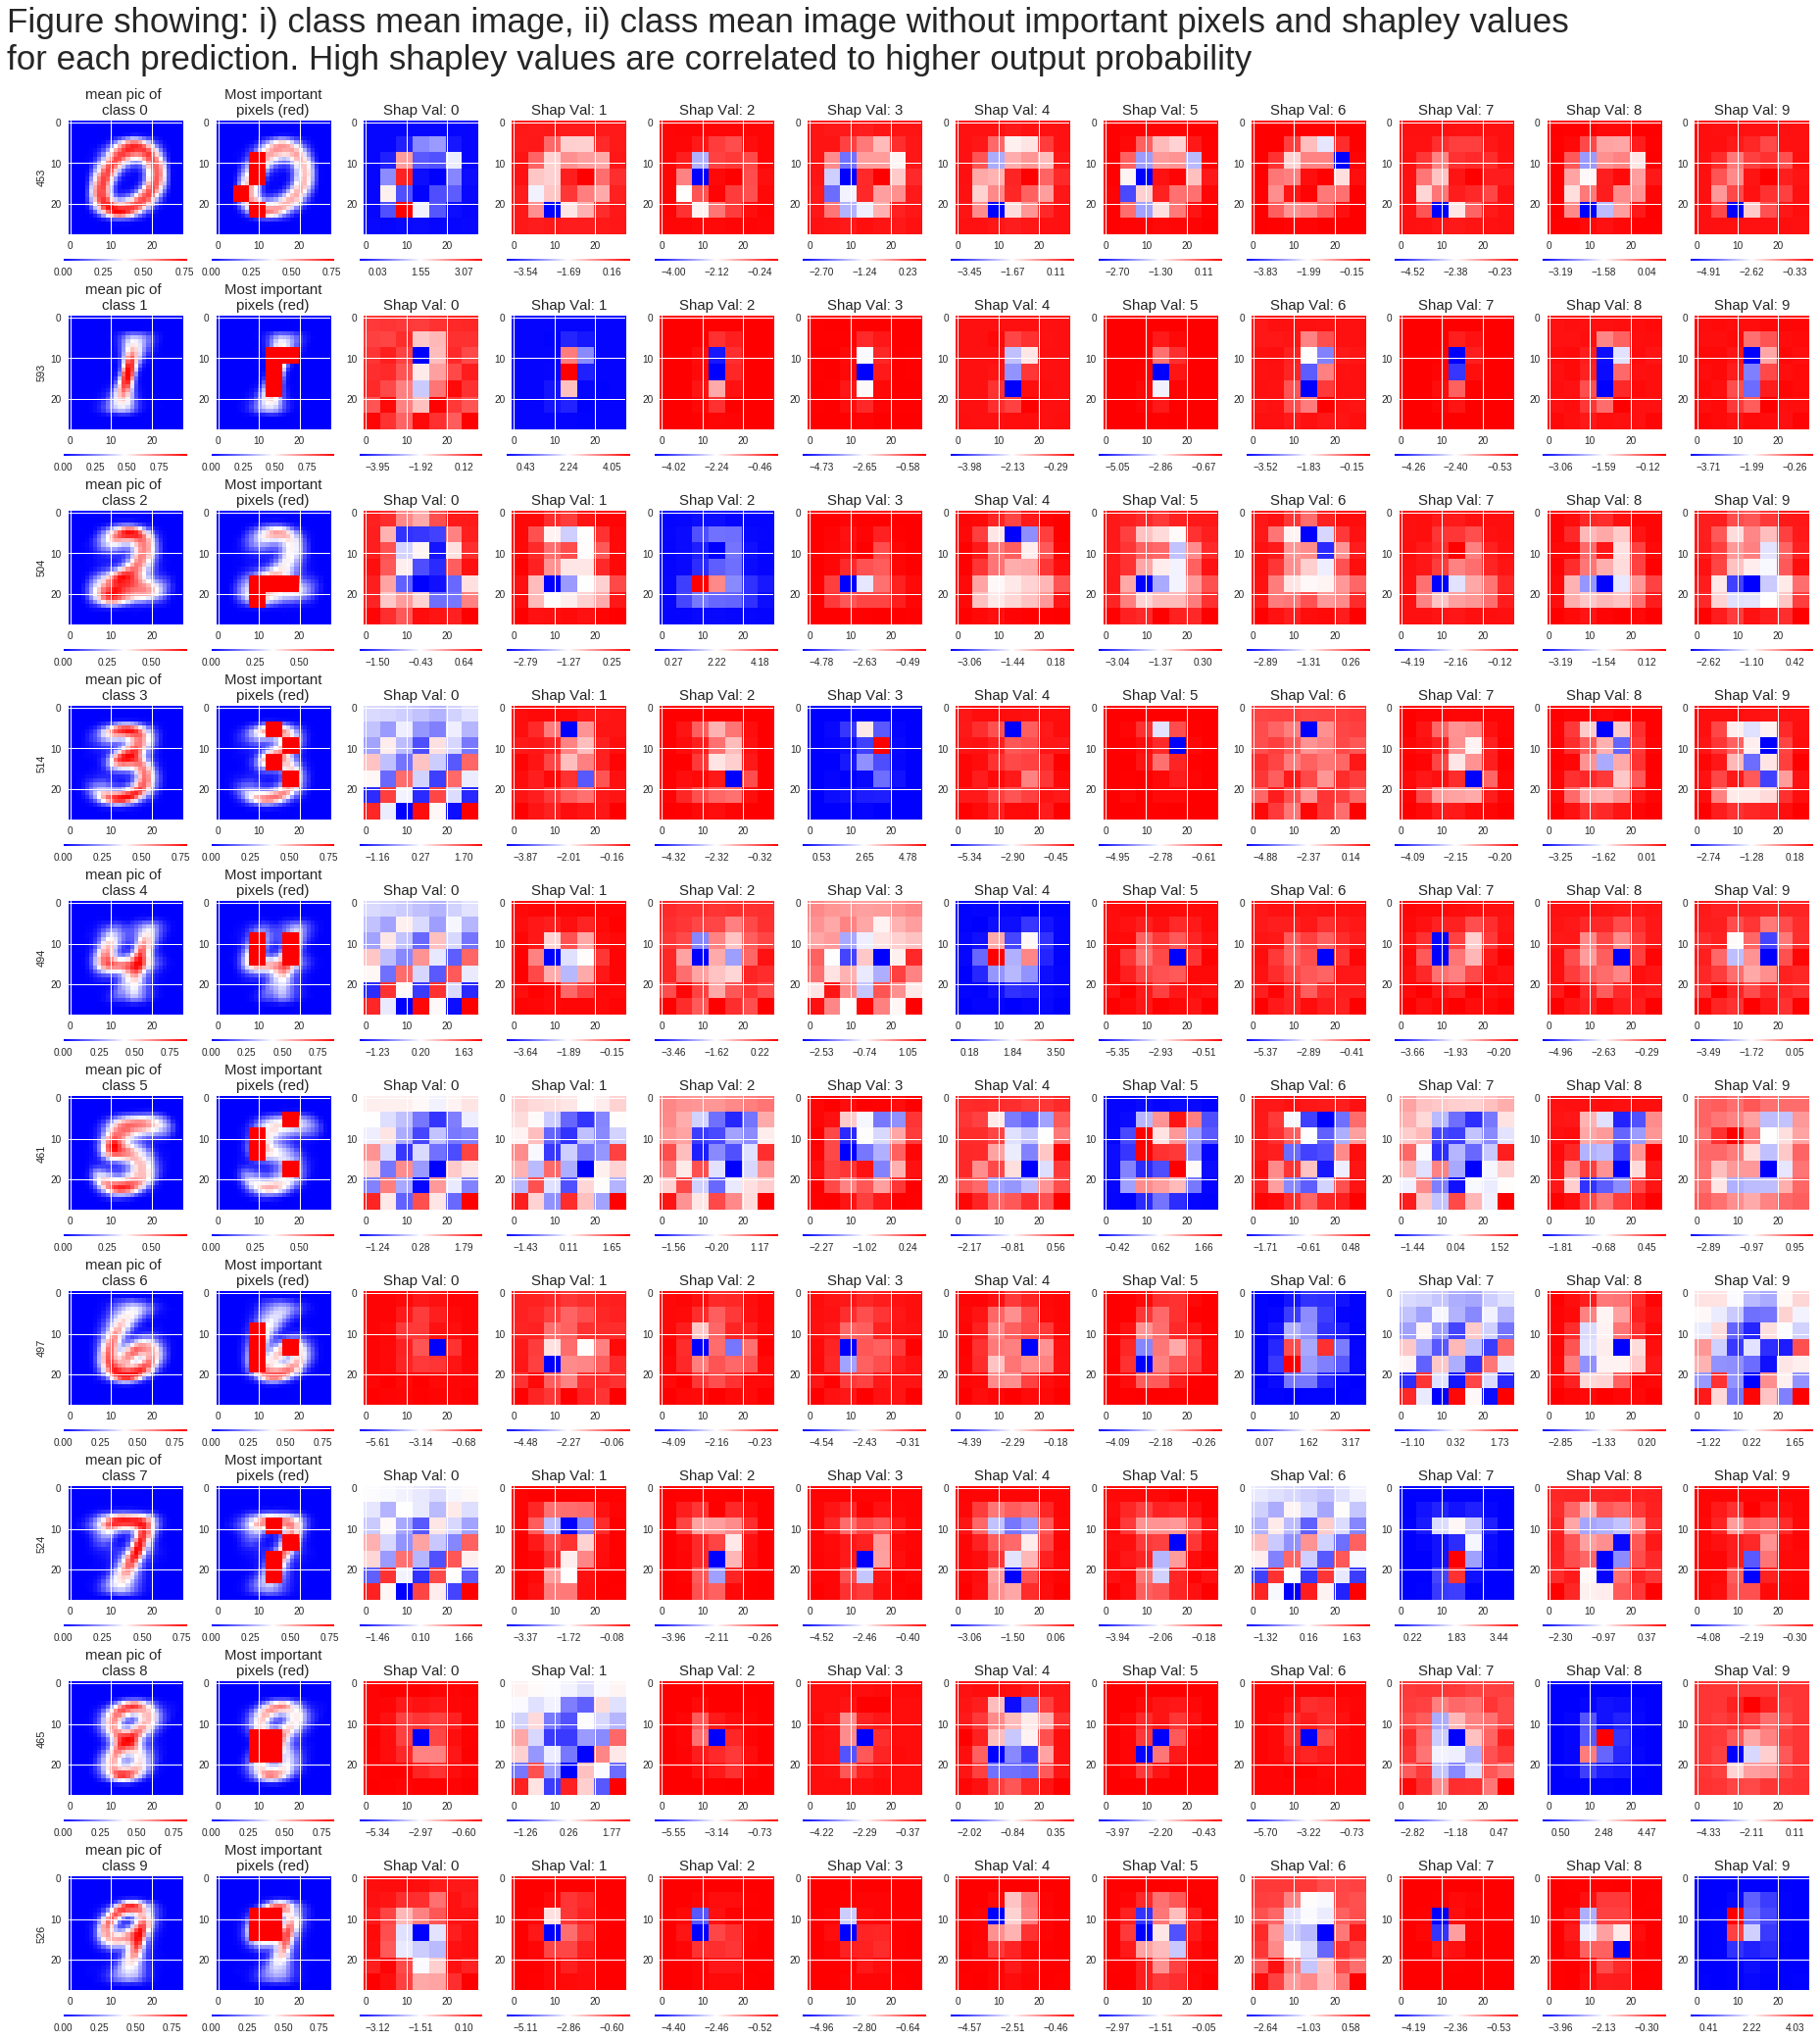

In [13]:
fontsize = 15
import copy
dictt_avg_plts = {}
f,ax = plt.subplots(10,12,figsize=(16*2,2*18))
plt.figtext(0.10, 0.90, 'Figure showing: i) class mean image, ii) class mean image without important pixels and shapley values\nfor each prediction. High shapley values are correlated to higher output probability', 
            horizontalalignment='left',fontsize=35) 
for digit in range(10):
    all_pic = np.stack([dictt[x][0][:,:,0] for x in dictt.keys() 
                  if (np.argmax(dictt[x][-1]) == digit and 
                    np.sum(np.isnan(np.stack(dictt[x][1],0)))==0)],0)
    avg_pic = np.mean(all_pic,0)
    cax1 = ax[digit,0].imshow(avg_pic,cmap = plt.cm.bwr)
    dictt_avg_plts[(digit,0)] = copy.deepcopy(avg_pic)
    cb = plt.colorbar(cax1,  ax=ax[digit,0],ticks=[0,.25,.5,.75], orientation="horizontal", aspect=70) 
    ax[digit,0].set_title('mean pic of \nclass %s'%digit,fontsize=fontsize)
    ax[digit,0].set_ylabel(len(all_pic))
    #a = np.stack([(np.stack(dictt[x][1],0)- np.stack([np.mean(dictt[x][1],1),],-1))/np.stack([np.std(dictt[x][1],1),],-1)
    #              for x in dictt.keys() 
    #              if (np.argmax(dictt[x][-1]) == digit and 
    #                  np.sum(np.isnan(np.stack(dictt[x][1],0)))==0)],0)
    a = np.stack([np.stack(dictt[x][1],0)
                  for x in dictt.keys() 
                  if (np.argmax(dictt[x][-1]) == digit and 
                      np.sum(np.isnan(np.stack(dictt[x][1],0)))==0)],0)
    phi = np.percentile(a,50,(0))
    phi = (phi - np.stack([np.mean(phi,-1),],-1))/np.stack([np.std(phi,-1),],-1)
    b = np.stack([np.stack(dictt[x][-1],0) for x in dictt.keys() 
                  if (np.argmax(dictt[x][-1]) == digit and 
                    np.sum(np.isnan(np.stack(dictt[x][1],0)))==0)],0)
    median_preds_for_digit = map(lambda x: np.round(x,1), np.log10(np.median(b,0)))
    for preds in range(0,10):
        shapley_image = np.copy(dictt[0][2].astype(np.float32))
        for x in range(28):
            for y in range(28):
                shapley_image[x,y] = phi[preds][int(shapley_image[x,y])]
        min_val = np.min(phi[preds])
        max_val = np.max(phi[preds])
        cax = ax[digit,preds+2].imshow(shapley_image,vmin=min_val, vmax=max_val,cmap = plt.cm.bwr)
        dictt_avg_plts[(digit,preds+2)] = copy.deepcopy(shapley_image)
        ax[digit,preds+2].set_title('Shap Val: %s%s' %(preds,''),fontsize=fontsize)
        max_minus_min_Phi = max_val-min_val
        cb = plt.colorbar(cax,  ax=ax[digit,preds+2],
                          ticks=map(lambda x : np.round(x,2),
                                [(max_val+min_val)*.5 - .35*max_minus_min_Phi,
                                 (max_val+min_val)*.5,
                                 (max_val+min_val)*.5 + .35*max_minus_min_Phi]), 
                          orientation="horizontal", aspect=70) 
        if preds == digit:
            largest_shap_val = np.percentile(np.concatenate(shapley_image),90)
            avg_pic[shapley_image > largest_shap_val] = 1 
            cax = ax[digit,1].imshow(avg_pic,cmap = plt.cm.bwr)
            ax[digit,1].set_title('Most important\npixels (red)',fontsize=fontsize)
            cb = plt.colorbar(cax1,  ax=ax[digit,1],ticks=[0,.25,.5,.75], orientation="horizontal", aspect=70) 
plt.savefig('Visual.png',dpi=200, bbox_inches='tight')
plt.show()
    
    


In [1]:
from matplotlib.gridspec import GridSpec
id_wrong_predict = np.argwhere((np.argmax(pred,-1) == np.argmax(y_val,-1))==0)
y_label_max = np.argmax(y_val,-1)
y_pred_max = np.argmax(pred,-1)
for i in id_wrong_predict:
    overlaid_img = np.zeros((28,28,3))
    #f,ax = plt.subplots(3,3,figsize=(9,10))
    fig=plt.figure(figsize=(17,9))

    gs=GridSpec(2,5) # 2 rows, 3 columns

    ax1=fig.add_subplot(gs[0,4]) # First row, first column
    ax2=fig.add_subplot(gs[0,2]) # First row, second column
    ax3=fig.add_subplot(gs[0,3]) # First row, third column
    ax0=fig.add_subplot(gs[:,:2]) # Second row, span all columns
    ax4=fig.add_subplot(gs[1,4]) # First row, first column
    ax5=fig.add_subplot(gs[1,2]) # First row, second column
    ax6=fig.add_subplot(gs[1,3])
    ax = [ax0,ax1,ax2,ax3,ax4,ax5,ax6]
    ax_id = 0
    preds_i = (100*model.predict(np.array([dictt[i[0]][0]]))).astype(np.int32)
    top2 =  np.argsort(preds_i)[0][-2:][::-1]
    cax = ax[0].imshow(dictt[i[0]][0][:,:,0],cmap = plt.cm.bwr)
    overlaid_img[:,:,0] = dictt[i[0]][0][:,:,0]
    ax[ax_id].set_title('Test Example: %s\nPredicted Digit: %s (%s%%), \nActual Digit: %s (%s%%)'
                        %(i[0],y_pred_max[i[0]],preds_i[0][y_pred_max[i[0]]],
                          y_label_max[i[0]],preds_i[0][y_label_max[i[0]]]),
                       fontsize=28)
    cb = plt.colorbar(cax,  ax=ax[ax_id],
                 orientation="horizontal")
    ax_id += 1
    phi = dictt[i[0]][1]
    phi = (phi - np.stack([np.mean(phi,-1),],-1))/np.stack([np.std(phi,-1),],-1)
    for ii in range(7):
            ax[ii].set_xticks(np.arange(0,28,4))
            ax[ii].set_yticks(np.arange(0,28,4))
    for digit in list(top2[:1:1])+[y_label_max[i[0]],]:# highest preduiction  plus actual label
        min_val =np.min(phi[digit])
        max_val = np.max(phi[digit])
        shapley_image = np.copy(dictt[0][2].astype(np.float32))
        counter =0 
        for x in range(28):
            for y in range(28):
                shapley_image[x,y] = phi[digit][int(shapley_image[x,y])]
                counter += 1
        cax = ax[ax_id].imshow(shapley_image,
                                vmin=min_val, vmax=max_val,
                                cmap = plt.cm.bwr)
        cb = plt.colorbar(cax,  ax=ax[ax_id],
                         orientation="horizontal")
        ax[ax_id].set_title('Test Example : %s\nshapley value for digit %s'%(i[0],digit),fontsize=18)
        ax_id += 1
        cax = ax[ax_id ].imshow(dictt_avg_plts[(digit,0)],cmap = plt.cm.bwr);
        cb = plt.colorbar(cax,  ax=ax[ax_id],
                         orientation="horizontal")
        ax[ax_id].set_title('Median pic of\nall digit %s'%digit,fontsize=18)
        ax_id += 1
        cax = ax[ax_id].imshow(dictt_avg_plts[(digit,2+digit)],cmap = plt.cm.bwr);
        cb = plt.colorbar(cax,  ax=ax[ax_id],
                         orientation="horizontal")
        ax[ax_id].set_title('Median shapley value\nof all digit %s'%digit,fontsize=18)
        ax_id += 1
        #cb = plt.colorbar(cax,  ax=ax[1,1+int(np.argwhere(top2 == digit)[0])],orientation="horizontal")
        overlaid_img[:,:,2] = dictt_avg_plts[(digit,0)]
    #ax[1,0].imshow(overlaid_img)
    plt.show();

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/usr/lib/python2.7/inspect.py", line 499, in getmodule
    os.path.realpath(f)] = module

IndexError: ignored